Loading dependency packages.



In [11]:
import sys
import os
import os.path
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.metrics import *

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


Superparameters for tuning.

In [12]:
# Features
processing_from = '2016-01-01'
processing_to = '2020-12-31'
label_columns = ['Weighted_Price']
input_features = 2
output_features = 3
Tx = 30
Ty = 1
shift = 1
cost_function="binary_crossentropy"
optimizer="adam"
BATCH_SIZE = 128
learning_rate = 0.0001
num_epochs = 50
L2_lambd = 0.0
beta1 = 0.0
beta2 = 0.0
epsilon = 0.0
LSTM_units = 512
LSTM_dropout = 0.1
dropout_rate = 0.1
CNN_filters = 64
CNN_kernels = 5

#INPUT_DATA
IN_PATH = os.path.abspath('F:/Work/DATA/BTC/')
trained_model_path = "BTC_daily_classifier.h5"
trained_model_figure_path = "BTC_daily_classifier_v2.png"
dataset_scaler_path = "20160101_20201231_daily.scl"
preprocessed_dataset_path = "20160101_20201231_daily.npy"

Define CSV reading function.

In [13]:
# data reading
def csv_reading(url, options):
  if options == 0:
    content = pd.read_csv(url)
    return content
  elif options == 1:
    file_id = url.split('/')[-2]
    path='https://drive.google.com/uc?export=download&id=' + file_id
    file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv'
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    fileDownloaded = drive.CreateFile({'id':file_id})
    fileDownloaded.GetContentFile(file_name)
    content = pd.read_csv(file_name)
    return content

Define preprocessing function to get daily trading data.

In [14]:
def daily_preprocess(df):
  price = df.resample('d', on='Timestamp')[['Weighted_Price']].mean()
  volume_usd = df.resample('d', on='Timestamp')[['Volume_(Currency)']].sum()
  close_price = df.resample('d', on='Timestamp')[['Close']].last('T')
  fig, axs = plt.subplots(3, 1, figsize=(20,10))
  fig.suptitle('Full BTC historical trading (daily)', fontsize= 18, color='b')
  axs[0].plot(price, 'g')
  axs[0].set_ylabel('BTC daily weighted price ($)')
  axs[1].plot(close_price, 'b')
  axs[1].set_ylabel('BTC daily close price ($)')
  axs[2].plot(volume_usd, 'r')
  axs[2].set_ylabel('BTC daily volume ($)')
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

  # removed NaN and slice data
  price.fillna(method ='bfill', inplace = True)
  close_price.fillna(method ='bfill', inplace = True)
  volume_usd.fillna(method ='bfill', inplace = True)
  price = price[processing_from:processing_to]
  close_price = close_price[processing_from:processing_to]
  volume_usd = volume_usd[processing_from:processing_to]
  fig, axs = plt.subplots(3, 1, figsize=(20,10))
  fig.suptitle('Sliced BTC historical trading (daily)', fontsize= 18, color='b')
  axs[0].plot(price, 'g')
  axs[0].set_ylabel('BTC daily weighted price ($)')
  axs[1].plot(close_price, 'b')
  axs[1].set_ylabel('BTC daily close price ($)')
  axs[2].plot(volume_usd, 'r')
  axs[2].set_ylabel('BTC volume (currency) ($)')
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()
  daily = pd.concat([price, volume_usd], join = 'outer', axis = 1)
  return daily

def dump_dataset(df, data_path, scaler_path, val_ratio, test_ratio):
  columns_name = df.columns
  scaler = preprocessing.MinMaxScaler()
  scaled = df.copy()
  print(scaled.head())
  scaler = scaler.fit(df)
  scaled[columns_name] = scaler.transform(df)
  print(scaled.head())
  X,y = convert_fit_data(scaled, label_columns, Tx, Ty, shift)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=1)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio/(1-test_ratio), random_state=1)
  # save
  joblib.dump(scaler, scaler_path)
  saved_data = {'X_train':X_train,'y_train':y_train,'X_val':X_val,'y_val':y_val, 'X_test':X_test,'y_test':y_test}
  np.save(data_path, saved_data)
  
  return (X_train, y_train, X_val, y_val, X_test, y_test, scaler)

def load_dataset(data_path, scaler_path):
  scaler = joblib.load(scaler_path)
  scaled_data = np.load(data_path,allow_pickle=True)[()]
  X_train = scaled_data['X_train']
  y_train = scaled_data['y_train']
  X_val = scaled_data['X_val']
  y_val = scaled_data['y_val']
  X_test = scaled_data['X_test']
  y_test = scaled_data['y_test']
  
  return X_train, y_train, X_val, y_val, X_test, y_test, scaler

Define models

In [15]:
def BTC_forecasting_model(num_of_input_features, Tx, num_of_out_features, Ty, LSTM_units, LSTM_dropout, dropout_rate):
  ''' v1
  model = Sequential()
  model.add(LSTM(LSTM_units, activation='relu', return_sequences=True, input_shape=(Tx, num_of_input_features), dropout=LSTM_dropout))
  model.add(Dropout(rate=dropout_rate))
  model.add(BatchNormalization())
  model.add(LSTM(LSTM_units, dropout=LSTM_dropout))
  model.add(Dropout(rate=dropout_rate))
  model.add(Dense(num_of_out_features, activation='sigmoid'))
  '''
  '''
  model = Sequential()
  model.add(LSTM(LSTM_units, activation='relu', return_sequences=True, input_shape=(Tx, num_of_input_features),dropout=LSTM_dropout))
  #model.add(BatchNormalization())
  model.add(LSTM(LSTM_units, activation='relu',dropout=LSTM_dropout))
  model.add(Dropout(rate=dropout_rate)(training=True))
  model.add(Dense(num_of_out_features))
  '''

  input_shape=(Tx, num_of_input_features)
  X_input = Input(input_shape)
  X = LSTM(LSTM_units, activation='relu', return_sequences=False, input_shape=input_shape, name='LSTM_1')(X_input)
  #X = BatchNormalization(name='BN_1')(X)
  #X = LSTM(LSTM_units, activation='relu',dropout=LSTM_dropout,name='LSTM_2')(X)
  #X = Dropout(rate=dropout_rate,name='Dropout_1')(X, training=True)
  X = Dense(num_of_out_features, activation='sigmoid',name='Full_1')(X)
  model = Model(inputs = X_input, outputs = X, name='BTC_forecasting')

  if optimizer == 'adam':
    opt = optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'SGD':
    opt = optimizers.SGD(learning_rate=learning_rate)
  model.compile(optimizer=opt, loss=cost_function, metrics=[MeanSquaredError()])
  return model

def BTC_daily_forecasting_multi_steps_model(num_of_input_features, Tx, num_of_out_features, Ty, LSTM_units, LSTM_dropout, dropout_rate):
  model = Sequential()
  model.add(LSTM(LSTM_units, activation='relu', input_shape=(Tx, num_of_input_features)))
  #model.add(Dropout(rate=dropout_rate))
  #model.add(BatchNormalization())
  #model.add(LSTM(LSTM_units, dropout=LSTM_dropout))
  model.add(Dense(Ty*num_of_out_features, activation='sigmoid'))
  model.add(Reshape((Ty, num_of_out_features)))
  
  if optimizer == 'adam':
    opt = optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'SGD':
    opt = optimizers.SGD(learning_rate=learning_rate)
  model.compile(optimizer=opt, loss=cost_function, metrics=[MeanSquaredError()])
  return model

def BTC_CRNN_classifier(num_of_input_features, Tx, num_of_out_features, Ty, LSTM_units, LSTM_dropout, CNN_filters, CNN_kernel, dropout_rate):
  input_shape=(Tx, num_of_input_features)
  '''
  X_input = Input(input_shape)
  X = Conv1D(filters=CNN_filters, kernel_size=CNN_kernel, activation='relu', strides=1, padding='same', name='CNN_1')(X_input)
  X = BatchNormalization(name='BN_1')(X, training=True)
  X = Dropout(dropout_rate)(X)
  X = LSTM(LSTM_units, activation='relu',dropout=LSTM_dropout,name='LSTM_1', input_shape=(Tx, CNN_filters))(X)
  X1 = Dense(16, activation='relu')(X)
  X2 = LSTM(LSTM_units, activation='relu',dropout=LSTM_dropout,name='LSTM_2', input_shape=input_shape)(X_input)
  X2 = Dense(16, activation='relu')(X2)
  X = Concatenate()([X1, X2])
  X = Dense(Ty*num_of_out_features)(X)
  X = Reshape((Ty, num_of_out_features))(X)
  X = Softmax(axis=1)(X)
  model = Model(inputs = X_input, outputs = X, name='BTC_CRNN_classifier')
  '''
  '''
  X_input = Input(input_shape)
  X = Conv1D(filters=CNN_filters, kernel_size=CNN_kernel, activation='relu', strides=1, padding='same', name='CNN_1')(X_input)
  X = BatchNormalization(name='BN_1')(X, training=True)
  X = Dropout(dropout_rate)(X)
  X = LSTM(LSTM_units, activation='relu',dropout=LSTM_dropout,name='LSTM_1', input_shape=(Tx, CNN_filters))(X)
  X1 = Dense(16, activation='relu')(X)
  X2 = LSTM(LSTM_units, activation='relu',dropout=LSTM_dropout,name='LSTM_2', input_shape=input_shape)(X_input)
  X2 = Dense(16, activation='relu')(X2)
  X = Concatenate()([X1, X2])
  X = Dense(Ty*num_of_out_features)(X)
  X = Reshape((Ty, num_of_out_features))(X)
  X = Softmax(axis=1)(X)
  model = Model(inputs = X_input, outputs = X, name='BTC_CRNN_classifier')
  '''

  X_input = Input(input_shape)
  X = Conv1D(filters=CNN_filters, kernel_size=CNN_kernel, activation='relu', strides=1, padding='same', name='CNN_1')(X_input)
  # X = BatchNormalization(name='BN_1')(X, training=True)
  # X = Dropout(dropout_rate)(X)
  #X = LSTM(LSTM_units, activation='relu', return_sequences=True, dropout=LSTM_dropout,name='LSTM_1', input_shape=input_shape)(X_input)
  X = LSTM(LSTM_units, activation='relu', dropout=LSTM_dropout,name='LSTM_1', input_shape=input_shape)(X)
  X1 = Dense(16, activation='relu')(X)
  X2 = LSTM(LSTM_units, activation='relu',dropout=LSTM_dropout,name='LSTM_2', input_shape=input_shape)(X_input)
  X2 = Dense(16, activation='relu')(X2)
  X = Concatenate()([X1, X2])
  X = Dense(64)(X)
  X = Dense(16)(X)
  X = Dense(Ty*num_of_out_features)(X)
  X = Reshape((Ty, num_of_out_features))(X)
  X = Softmax(axis=2)(X)
  model = Model(inputs = X_input, outputs = X, name='BTC_CRNN_classifier')

  if optimizer == 'adam':
    opt = optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'SGD':
    opt = optimizers.SGD(learning_rate=learning_rate)
  model.compile(optimizer=opt, loss=cost_function, metrics=['accuracy',Precision(), Recall()])
  return model


Define data generators

In [16]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               input_df,
               label_columns=None):
    # Store the raw data.
    self.input_df = input_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(input_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
def sequence_data_generator(df, label_columns, input_len, output_len, shift, batch_size):
  total_window_size = input_len + shift
  inputs = np.array(df)
  labels = np.array(df[label_columns])
  x_shape = (batch_size, input_len, inputs.shape[1])
  x_batch = np.zeros(shape=x_shape, dtype=np.float16)
  y_shape = (batch_size, output_len, 1)
  y_batch = np.zeros(shape=y_shape, dtype=np.float16)

  while True:
    for i in range(batch_size):
      idx = np.random.randint(len(inputs) - total_window_size)
      x_batch[i] = inputs[idx:idx+input_len]
      y_batch[i] = labels[idx + total_window_size-output_len:idx + total_window_size]
    yield (x_batch, y_batch)

def convert_fit_data(df, label_columns, input_len, output_len, shift):
    data_x = []
    data_y = []
    for i in range(len(df) - input_len - shift):
        x_floats = np.array(df.iloc[i:i+input_len])
        y_floats = np.zeros((output_len, output_features))
        for j in range(output_len):
          diff = np.array(df[label_columns].iloc[i+input_len+shift-output_len + j]) - np.array(df[label_columns].iloc[i+input_len+shift-output_len + j - 1])
          diff = np.asscalar(diff)
          if abs(diff) < 0.0001:
            y_floats[j, 0] = 1
          elif diff < -0.0001:
            y_floats[j, 1] = 1
          elif diff > 0.0001:
            y_floats[j, 2] = 1
        data_x.append(x_floats)
        data_y.append(y_floats)
    return np.array(data_x), np.array(data_y)

Loading dataset from Google drive, Visualize and prepare fit data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727777 entries, 0 to 4727776
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Timestamp          datetime64[ns]
 1   Open               float64       
 2   High               float64       
 3   Low                float64       
 4   Close              float64       
 5   Volume_(BTC)       float64       
 6   Volume_(Currency)  float64       
 7   Weighted_Price     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 288.6 MB
None


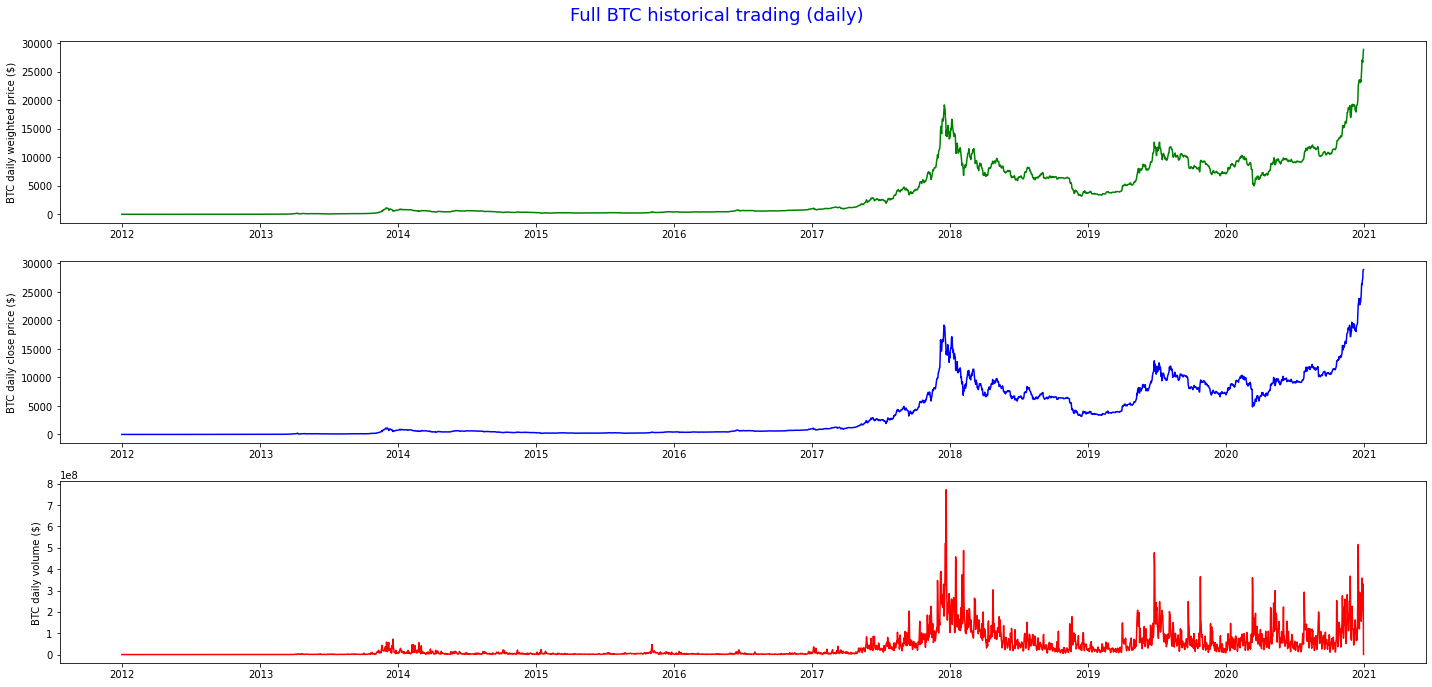

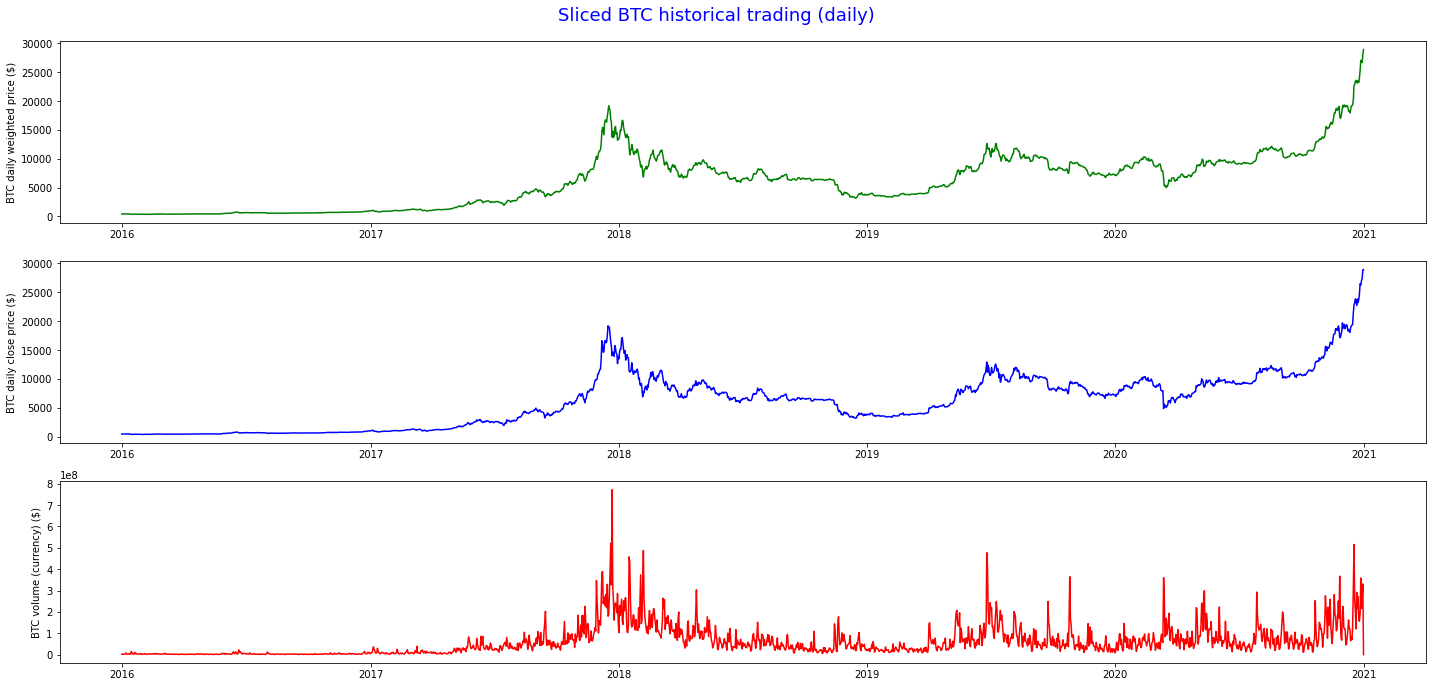

            Weighted_Price  Volume_(Currency)
Timestamp                                    
2016-01-01      432.762815       1.640578e+06
2016-01-02      433.102496       1.287773e+06
2016-01-03      429.069676       1.959153e+06
2016-01-04      432.434197       2.474772e+06
2016-01-05      432.353912       1.677111e+06
            Weighted_Price  Volume_(Currency)
Timestamp                                    
2016-01-01        0.002163           0.001910
2016-01-02        0.002175           0.001453
2016-01-03        0.002034           0.002322
2016-01-04        0.002152           0.002990
2016-01-05        0.002149           0.001957


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


train shape: (1077, 30, 2)
train label size: (1077, 1, 3)
validate shape: (359, 30, 2)
test shape: (360, 30, 2)


In [17]:

dataset_url='https://drive.google.com/file/d/16AoK0vKAIshdyO96Td4Vfmnf_6cdTBko/view?usp=sharing'
btc = csv_reading(dataset_url, 1)
btc['Timestamp'] = pd.to_datetime(btc.Timestamp, unit='s')
print(btc.info())
daily = daily_preprocess(btc)
X_train, y_train, X_validate, y_validate, X_test, y_test, scaler = dump_dataset(daily, preprocessed_dataset_path, dataset_scaler_path, 0.2, 0.2)
#(X_train, y_train, X_validate, y_validate, X_test, y_test, scaler) = load_dataset(preprocessed_dataset_path, dataset_scaler_path)

print('train shape: ' + str(X_train.shape))
print('train label size: ' + str(y_train.shape))
print('validate shape: ' + str(X_validate.shape))
print('test shape: ' + str(X_test.shape))

Model, train and validate.

Model: "BTC_CRNN_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30, 2)]      0                                            
__________________________________________________________________________________________________
CNN_1 (Conv1D)                  (None, 30, 64)       704         input_2[0][0]                    
__________________________________________________________________________________________________
LSTM_1 (LSTM)                   (None, 512)          1181696     CNN_1[0][0]                      
__________________________________________________________________________________________________
LSTM_2 (LSTM)                   (None, 512)          1054720     input_2[0][0]                    
________________________________________________________________________________

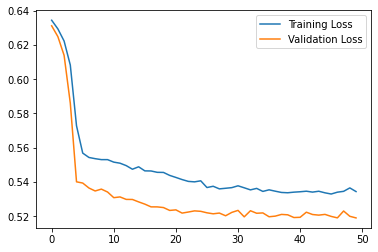

In [18]:
checkpoint = ModelCheckpoint(trained_model_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
#model = BTC_forecasting_model(input_features, Tx, output_features, Ty, LSTM_units, LSTM_dropout, dropout_rate)
#model = BTC_daily_forecasting_multi_steps_model(input_features, Tx, output_features, Ty, LSTM_units, LSTM_dropout, dropout_rate)
model = BTC_CRNN_classifier(input_features, Tx, output_features, Ty, LSTM_units, LSTM_dropout, CNN_filters, CNN_kernels, dropout_rate)
model.summary()
tf.keras.utils.plot_model(model, to_file=trained_model_figure_path, show_shapes=True, show_layer_names=True, expand_nested=False, dpi=96)
#history = model.fit(sequence_data_generator(train, label_columns, Tx, Ty, shift, BATCH_SIZE),validation_data=sequence_data_generator(validate, label_columns, Tx, Ty, shift, BATCH_SIZE),validation_steps=len(validate)-Tx-shift, steps_per_epoch=len(train)-Tx-shift, epochs=num_epochs)
history = model.fit(X_train, y_train,epochs=num_epochs, batch_size=BATCH_SIZE, callbacks=[checkpoint], shuffle=True, validation_data=(X_validate, y_validate))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

# predict on train/test dataset
#test_pred = model.predict(sequence_data_generator(test, label_columns, Tx, Ty, shift, len(test) - shift - Tx), steps=1)
#test_true = np.array(test[['Weighted_Price']])[Tx+shift-Ty:,0]
#train_pred = model.predict(sequence_data_generator(train, label_columns, Tx, Ty, shift, len(train) - shift - Tx), steps=1)
#train_true = np.array(train[['Weighted_Price']])[Tx+shift-Ty:,0]

test_true = np.copy(y_test)
train_true = np.copy(y_train)
test_pred = model.predict(X_test)
test_true = test_true.reshape(test_pred.shape)
train_pred = model.predict(X_train)
train_true = train_true.reshape(train_pred.shape)
train_mse = tf.keras.losses.MeanSquaredError()(train_true, train_pred).numpy()
test_mse = tf.keras.losses.MeanSquaredError()(test_true, test_pred).numpy()
# transform to original value
train_pred = tf.argmax(train_pred, axis = 2).numpy()
train_true = tf.argmax(train_true, axis = 2).numpy()
accuracy = accuracy_score(train_true, train_pred)
precision = precision_score(train_true, train_pred, average='micro')
recall = recall_score(train_true, train_pred, average='micro')
f1 = f1_score(train_true, train_pred, average='micro')
print('accuracy:' + str(accuracy))
print('Precision:' + str(precision))
print('recall:' + str(recall))
print('f1:' + str(f1))
